In [1]:
# 📦 Install required dependencies
!pip install xgboost shap pandas scikit-learn --quiet


In [2]:
# 📚 Standard imports
import json
import pandas as pd
from collections import defaultdict
from datetime import datetime
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap
import warnings

warnings.filterwarnings('ignore', category=UserWarning)


In [3]:
# 📥 Load JSON Txns
def load_transactions(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

In [4]:

# 🧠 Feature extraction from Tx history
def extract_wallet_features(transactions):
    wallets = defaultdict(lambda: {
        'deposits': 0,
        'redeems': 0,
        'borrows': 0,
        'repays': 0,
        'liquidations': 0,
        'liquidations_as_liquidator': 0,
        'timestamps': []
    })

    for tx in transactions:
        action = tx.get('action', '').lower()
        wallet = tx['userWallet']
        ts = tx['timestamp']

        if action == 'deposit':
            wallets[wallet]['deposits'] += 1
        elif action == 'redeemunderlying':
            wallets[wallet]['redeems'] += 1
        elif action == 'borrow':
            wallets[wallet]['borrows'] += 1
        elif action == 'repay':
            wallets[wallet]['repays'] += 1
        elif action == 'liquidationcall':
            actor = tx['actionData'].get('userId')
            if actor == wallet:
                wallets[wallet]['liquidations'] += 1
            else:
                wallets[wallet]['liquidations_as_liquidator'] += 1

        wallets[wallet]['timestamps'].append(ts)

    data = []
    for wallet, f in wallets.items():
        span = (max(f['timestamps']) - min(f['timestamps'])) / (3600 * 24) if len(f['timestamps']) > 1 else 1
        repay_ratio = f['repays'] / f['borrows'] if f['borrows'] > 0 else 0
        liquidation_rate = f['liquidations'] / f['borrows'] if f['borrows'] > 0 else 0

        data.append({
            'wallet': wallet,
            'deposits': f['deposits'],
            'redeems': f['redeems'],
            'borrows': f['borrows'],
            'repays': f['repays'],
            'liquidations': f['liquidations'],
            'liquidations_as_liquidator': f['liquidations_as_liquidator'],
            'duration_days': round(span, 2),
            'repay_ratio': round(repay_ratio, 4),
            'liquidation_rate': round(liquidation_rate, 4)
        })

    return pd.DataFrame(data)


In [5]:

# 🏷️ Pseudo-label based on risk
def get_pseudo_labels(df):
    return ((df['liquidation_rate'] > 0.25) | ((df['repay_ratio'] < 0.5) & (df['borrows'] > 0))).astype(int)

# 🧠 Train machine learning model
def train_xgboost_model(df, features, labels):
    X_train, X_test, y_train, y_test = train_test_split(df[features], labels, test_size=0.2, random_state=42)
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss'
    )
    model.fit(X_train, y_train)
    return model

# 🥇 Predict scores and explain with SHAP
def score_wallets_with_shap(model, df, features):
    explainer = shap.TreeExplainer(model)
    X = df[features]
    risk_probs = model.predict_proba(X)[:, 1]
    credit_scores = ((1 - risk_probs) * 1000).astype(int)
    df['credit_score'] = credit_scores
    shap_vals = explainer.shap_values(X)

    output = []
    for i, row in df.iterrows():
        shap_impacts = sorted(
            zip(features, shap_vals[i]),
            key=lambda x: abs(x[1]),
            reverse=True
        )
        output.append({
            'wallet': row['wallet'],
            'credit_score': int(row['credit_score']),
            'top_features': [
                {'feature': f, 'impact': round(v, 4)}
                for f, v in shap_impacts[:5]
            ]
        })
    return output


In [6]:
# 📁 Upload your DeFi transaction JSON file
from google.colab import files
uploaded = files.upload()

# 📝 Get filename
file_name = list(uploaded.keys())[0]
print(f"📄 File uploaded: {file_name}")


Saving user-wallet-transactions.json to user-wallet-transactions (1).json
📄 File uploaded: user-wallet-transactions (1).json


In [8]:
import json
import numpy as np

# 🚀 Main scoring function
def main(input_file='sample.json', output_file='wallet_scores.json'):
    print("⚙️ Loading transactions...")
    txns = load_transactions(input_file)
    print(f"✅ Loaded {len(txns)} transactions")

    print("🔍 Extracting wallet features...")
    df = extract_wallet_features(txns)
    if df.empty:
        print("❌ No valid wallets found")
        return

    features = df.columns.difference(['wallet'])
    y = get_pseudo_labels(df)
    print(f"📊 {len(df)} wallets found. Training model...")

    model = train_xgboost_model(df, features, y)
    print("🧠 Scoring wallets and explaining results with SHAP...")

    results = score_wallets_with_shap(model, df, features)

    # ✅ Convert numpy types to native Python types for JSON serialization
    def convert_numpy_types(obj):
        if isinstance(obj, np.generic):
            return obj.item()
        elif isinstance(obj, dict):
            return {k: convert_numpy_types(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy_types(i) for i in obj]
        else:
            return obj

    cleaned_results = convert_numpy_types(results)

    with open(output_file, 'w') as f:
        json.dump(cleaned_results, f, indent=2)

    print(f"\n✅ Done! Output saved to {output_file}")
    return cleaned_results


# ✅ Run the pipeline
results = main(input_file=file_name)


⚙️ Loading transactions...
✅ Loaded 100000 transactions
🔍 Extracting wallet features...
📊 3497 wallets found. Training model...
🧠 Scoring wallets and explaining results with SHAP...

✅ Done! Output saved to wallet_scores.json


In [9]:
# 👁️ View top 5 scored wallets
for r in results[:5]:
    print(json.dumps(r, indent=2))


{
  "wallet": "0x00000000001accfa9cef68cf5371a23025b6d4b6",
  "credit_score": 999,
  "top_features": [
    {
      "feature": "borrows",
      "impact": -6.9415998458862305
    },
    {
      "feature": "repay_ratio",
      "impact": 1.6190999746322632
    },
    {
      "feature": "duration_days",
      "impact": -0.18140000104904175
    },
    {
      "feature": "liquidation_rate",
      "impact": -0.12300000339746475
    },
    {
      "feature": "repays",
      "impact": 0.026399999856948853
    }
  ]
}
{
  "wallet": "0x000000000051d07a4fb3bd10121a343d85818da6",
  "credit_score": 999,
  "top_features": [
    {
      "feature": "borrows",
      "impact": -6.9415998458862305
    },
    {
      "feature": "repay_ratio",
      "impact": 1.6190999746322632
    },
    {
      "feature": "duration_days",
      "impact": -0.18140000104904175
    },
    {
      "feature": "liquidation_rate",
      "impact": -0.12300000339746475
    },
    {
      "feature": "repays",
      "impact": 0.02639

In [10]:
from google.colab import files
files.download("wallet_scores.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

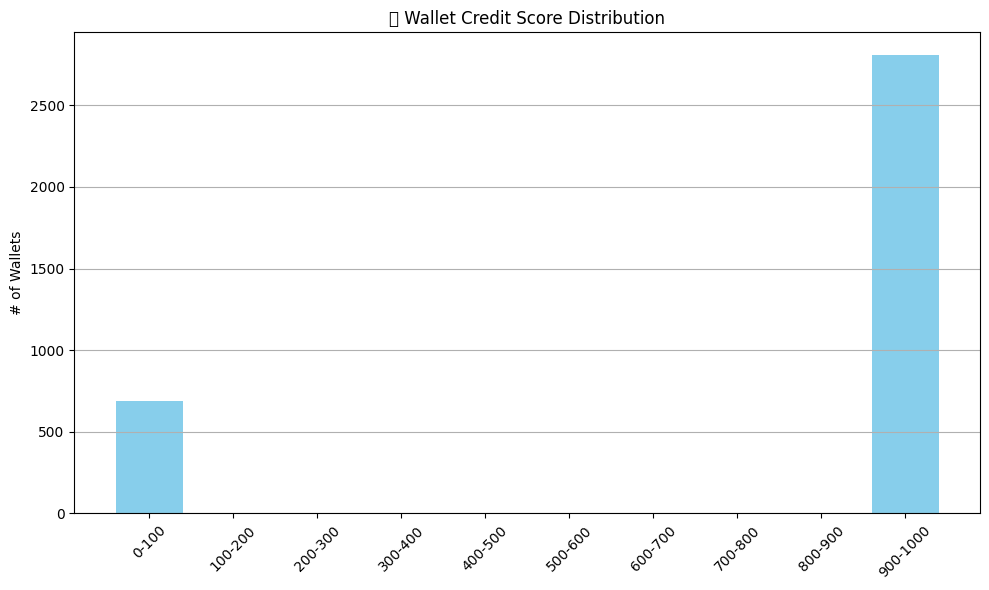

In [11]:
import matplotlib.pyplot as plt
import json

# Load wallet score output
with open("wallet_scores.json") as f:
    data = json.load(f)

bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
labels = [f"{b}-{b+100}" for b in bins[:-1]]
counts = {label: 0 for label in labels}

for d in data:
    s = d["credit_score"]
    for i in range(len(bins)-1):
        if bins[i] <= s < bins[i+1]:
            counts[labels[i]] += 1
            break

# Plot
plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title("🧮 Wallet Credit Score Distribution")
plt.ylabel("# of Wallets")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("score_distribution.png")
plt.show()
